# Aaditya Vyas - TripleTen Final Project

* The telecommunications operator Interconnect would like to forecast the churn of their clients
* Interconnect wants to be able to identify customers who are planning on leaving the service
* In order to combat the departure of a customer, Interconnect would offer customers who might cancel their service promotional discount codes and special offers to entice them to stay
* Using data provided by Interconnect, the goal will be to determine whether "YES" a customer will likely cancel their plan or "NO" they will not

## Work Plan

1. Data Loading & Preprocessing
    * Load all dataframes into notebook
    * Observe if there are any null values or duplicates
    * Convert data if necessary
    * Merge datasets into one based on Customer ID
    * Cleanup:
        * Make column titles lowercase 
2. EDA
    * Examine how features impact target (contract end date)
3. Model Preparation
    * Split data into training, testing, and validation datasets
    * Apply one-hot encoding to specific columns (for example, internet connection type)
    * Apply scaling to numerical columns (such as monthly charges)
4. Model Processing
    * Train models to observe best output for AUC-ROC score (must be greater than 0.75 - ideally better than 0.85)
    * Potential Models:
        * Decision Tree Classifier
        * Random Tree Classifier
        * CatBoost Classifer
        * Light GBM Classifer
        * XGBoost Classifer
5. Hyperparameter Tuning
    * Evaluate best model from above and determine best parameters for model
    * Test best model using tuned parameters
6. Conclusion
    * Summarize findings
    * Present best found model
    * Provide reccommendations for reducing customer churn

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Load & Look at Data

In [3]:
try:
    contract = pd.read_csv('contract.csv')
except:
    contract = pd.read_csv('/datasets/contract.csv')

In [4]:
try:
    internet = pd.read_csv('internet.csv')
except:
    internet = pd.read_csv('/datasets/internet.csv')

In [5]:
try:
    personal = pd.read_csv('personal.csv')
except:
    personal = pd.read_csv('/datasets/personal.csv')

In [6]:
try:
    phone = pd.read_csv('phone.csv')
except:
    phone = pd.read_csv('/datasets/phone.csv')

In [7]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [10]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [11]:
contract.duplicated().sum()

0

In [12]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [15]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [16]:
internet.duplicated().sum()

0

In [17]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [20]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [21]:
personal.duplicated().sum()

0

In [22]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [23]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [25]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [26]:
phone.duplicated().sum()

0

## Merge Dataframes

In [27]:
x = contract.merge(internet, on='customerID', how='outer')
x

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.60,593.3,DSL,No,Yes,No,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,542.4,DSL,No,No,No,No,No,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.90,280.85,Fiber optic,No,No,Yes,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.00,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.90,267.4,Fiber optic,No,No,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,2019-01-01,No,One year,No,Mailed check,55.15,742.9,DSL,Yes,No,No,Yes,No,No
7039,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7,Fiber optic,No,No,No,No,No,Yes
7040,9992-UJOEL,2019-12-01,No,Month-to-month,Yes,Mailed check,50.30,92.75,DSL,No,Yes,No,No,No,No
7041,9993-LHIEB,2014-07-01,No,Two year,No,Mailed check,67.85,4627.65,DSL,Yes,No,Yes,Yes,No,Yes


In [28]:
x2 = x.merge(personal, on='customerID', how='outer')
x2

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.60,593.3,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,542.4,DSL,No,No,No,No,No,Yes,Male,0,No,No
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.90,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.00,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.90,267.4,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,2019-01-01,No,One year,No,Mailed check,55.15,742.9,DSL,Yes,No,No,Yes,No,No,Female,0,No,No
7039,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7,Fiber optic,No,No,No,No,No,Yes,Male,0,Yes,No
7040,9992-UJOEL,2019-12-01,No,Month-to-month,Yes,Mailed check,50.30,92.75,DSL,No,Yes,No,No,No,No,Male,0,No,No
7041,9993-LHIEB,2014-07-01,No,Two year,No,Mailed check,67.85,4627.65,DSL,Yes,No,Yes,Yes,No,Yes,Male,0,Yes,Yes


In [29]:
data = x2.merge(phone, on='customerID', how='outer')
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.60,593.3,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,542.4,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.90,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.00,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.90,267.4,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,2019-01-01,No,One year,No,Mailed check,55.15,742.9,DSL,Yes,No,No,Yes,No,No,Female,0,No,No,No
7039,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7,Fiber optic,No,No,No,No,No,Yes,Male,0,Yes,No,Yes
7040,9992-UJOEL,2019-12-01,No,Month-to-month,Yes,Mailed check,50.30,92.75,DSL,No,Yes,No,No,No,No,Male,0,No,No,No
7041,9993-LHIEB,2014-07-01,No,Two year,No,Mailed check,67.85,4627.65,DSL,Yes,No,Yes,Yes,No,Yes,Male,0,Yes,Yes,No


## Merged df Cleanup

In [30]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   internetservice   5517 non-null   object 
 9   onlinesecurity    5517 non-null   object 
 10  onlinebackup      5517 non-null   object 
 11  deviceprotection  5517 non-null   object 
 12  techsupport       5517 non-null   object 
 13  streamingtv       5517 non-null   object 
 14  streamingmovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  seniorcitizen     7043 non-null   int64  


* Create a "churned" column to display YES, a customer has chosen to end their contract (1) or NO - they still use interconnect (0)

In [31]:
data['churned'] = data['enddate'].apply(lambda x: '1' if x != 'No' else '0')
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,churned
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,DSL,No,...,No,Yes,Yes,No,Female,0,Yes,Yes,No,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,DSL,No,...,No,No,No,Yes,Male,0,No,No,Yes,0
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,...,Yes,No,No,No,Male,0,No,No,No,1
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,...,Yes,No,Yes,Yes,Male,1,Yes,No,No,1
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Fiber optic,No,...,No,Yes,Yes,No,Female,1,Yes,No,No,1


* Clean up 'total charges' column - column is displayed as an object, but should be a number we can analyze

In [32]:
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
 8   internetservice   5517 non-null   object 
 9   onlinesecurity    5517 non-null   object 
 10  onlinebackup      5517 non-null   object 
 11  deviceprotection  5517 non-null   object 
 12  techsupport       5517 non-null   object 
 13  streamingtv       5517 non-null   object 
 14  streamingmovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  seniorcitizen     7043 non-null   int64  


In [33]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,churned
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.30,DSL,No,...,No,Yes,Yes,No,Female,0,Yes,Yes,No,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.40,DSL,No,...,No,No,No,Yes,Male,0,No,No,Yes,0
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,...,Yes,No,No,No,Male,0,No,No,No,1
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,...,Yes,No,Yes,Yes,Male,1,Yes,No,No,1
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.40,Fiber optic,No,...,No,Yes,Yes,No,Female,1,Yes,No,No,1


* Convert columns marked as "YES" and "NO" to 1/0 for easier analysis going forward

In [34]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,churned
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.30,DSL,No,...,No,Yes,Yes,No,Female,0,Yes,Yes,No,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.40,DSL,No,...,No,No,No,Yes,Male,0,No,No,Yes,0
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,...,Yes,No,No,No,Male,0,No,No,No,1
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,...,Yes,No,Yes,Yes,Male,1,Yes,No,No,1
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.40,Fiber optic,No,...,No,Yes,Yes,No,Female,1,Yes,No,No,1


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
 8   internetservice   5517 non-null   object 
 9   onlinesecurity    5517 non-null   object 
 10  onlinebackup      5517 non-null   object 
 11  deviceprotection  5517 non-null   object 
 12  techsupport       5517 non-null   object 
 13  streamingtv       5517 non-null   object 
 14  streamingmovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  seniorcitizen     7043 non-null   int64  


* Add a "duration" column to show how long customers have used services
    * For end dates which have "NO" - use latest date provided by dataset

In [37]:
data['enddate'].value_counts(ascending=False)

enddate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [38]:
data['enddate'] = data['enddate'].replace('No', '2020-01-01 00:00:00')

In [39]:
data['enddate'].value_counts(ascending=False)

enddate
2020-01-01 00:00:00    5634
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [40]:
data['begindate'] = pd.to_datetime(data['begindate'])
data['enddate'] = pd.to_datetime(data['enddate'])

In [41]:
data['duration'] = (data['enddate']-data['begindate']).dt.days
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,churned,duration
0,0002-ORFBO,2019-05-01,2020-01-01,One year,Yes,Mailed check,65.6,593.30,DSL,No,...,Yes,Yes,No,Female,0,Yes,Yes,No,0,245
1,0003-MKNFE,2019-05-01,2020-01-01,Month-to-month,No,Mailed check,59.9,542.40,DSL,No,...,No,No,Yes,Male,0,No,No,Yes,0,245
2,0004-TLHLJ,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,...,No,No,No,Male,0,No,No,No,1,122
3,0011-IGKFF,2018-12-01,2020-01-01,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,...,No,Yes,Yes,Male,1,Yes,No,No,1,396
4,0013-EXCHZ,2019-09-01,2019-12-01,Month-to-month,Yes,Mailed check,83.9,267.40,Fiber optic,No,...,Yes,Yes,No,Female,1,Yes,No,No,1,91


### Merged df Cleanup Notes
* Total charges was converted to a numeric datatype
* Column names were converted to lowercase 
* A "churned" column was added to show whether a customer was churned or not (1 = YES customer churned, or 0 = NO customer did not leave)
* A "duration" column was also added to show the total time in days a customer has stayed with Interconnect

## EDA

* Churned status of categorical columns

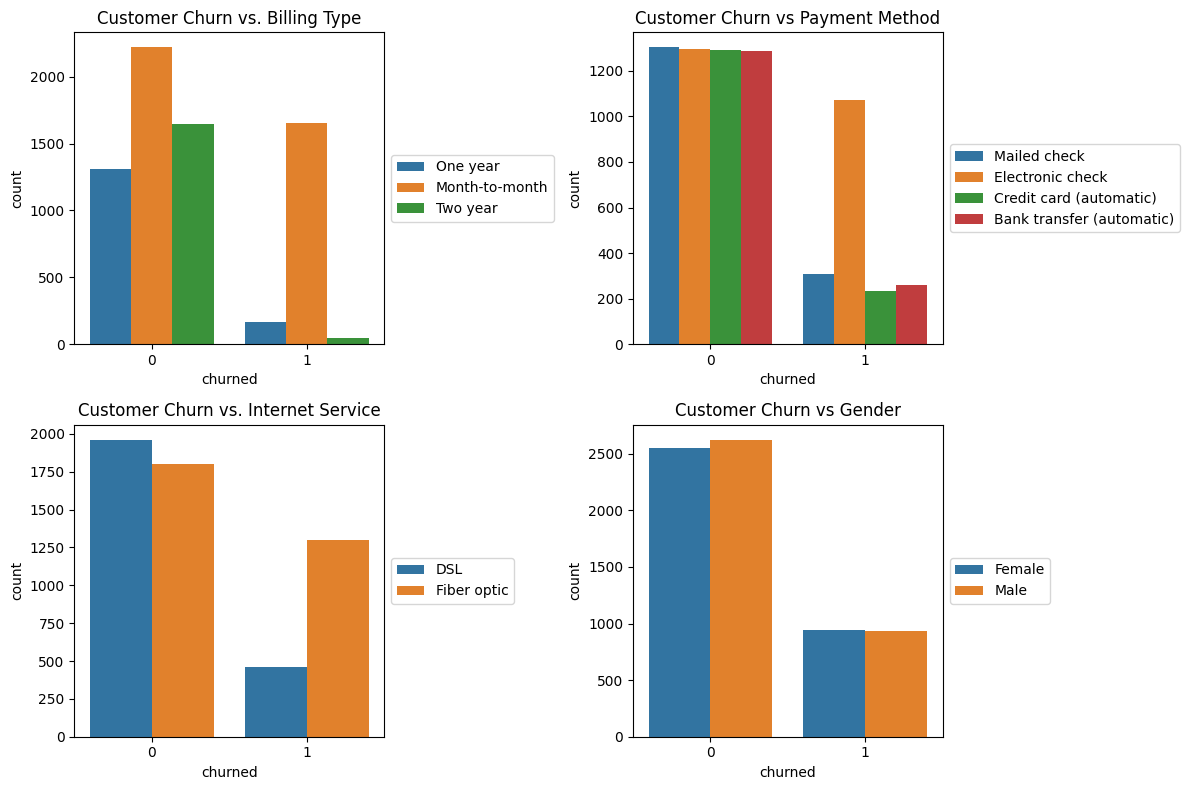

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(data=data, x='churned', hue='type', ax=axes[0, 0])
axes[0, 0].set_title('Customer Churn vs. Billing Type')
axes[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='paymentmethod', ax=axes[0, 1])
axes[0, 1].set_title('Customer Churn vs Payment Method')
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='internetservice', ax=axes[1, 0])
axes[1, 0].set_title('Customer Churn vs. Internet Service')
axes[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='gender', ax=axes[1, 1])
axes[1, 1].set_title('Customer Churn vs Gender')
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()

* Billing Type
    * It's clear that customers on a month-to-month contract churn more often than those on longer contracts
    * Month-to-month contracts provide customers with the flexibility to leave whichever monthy they desire
* Payment Method
    * Customers who paid by electronic checks churned the most
* Internet Service
    * Fiber optic customers churned more often than DSL
* Gender
    * The churn between genders of the customers was about even

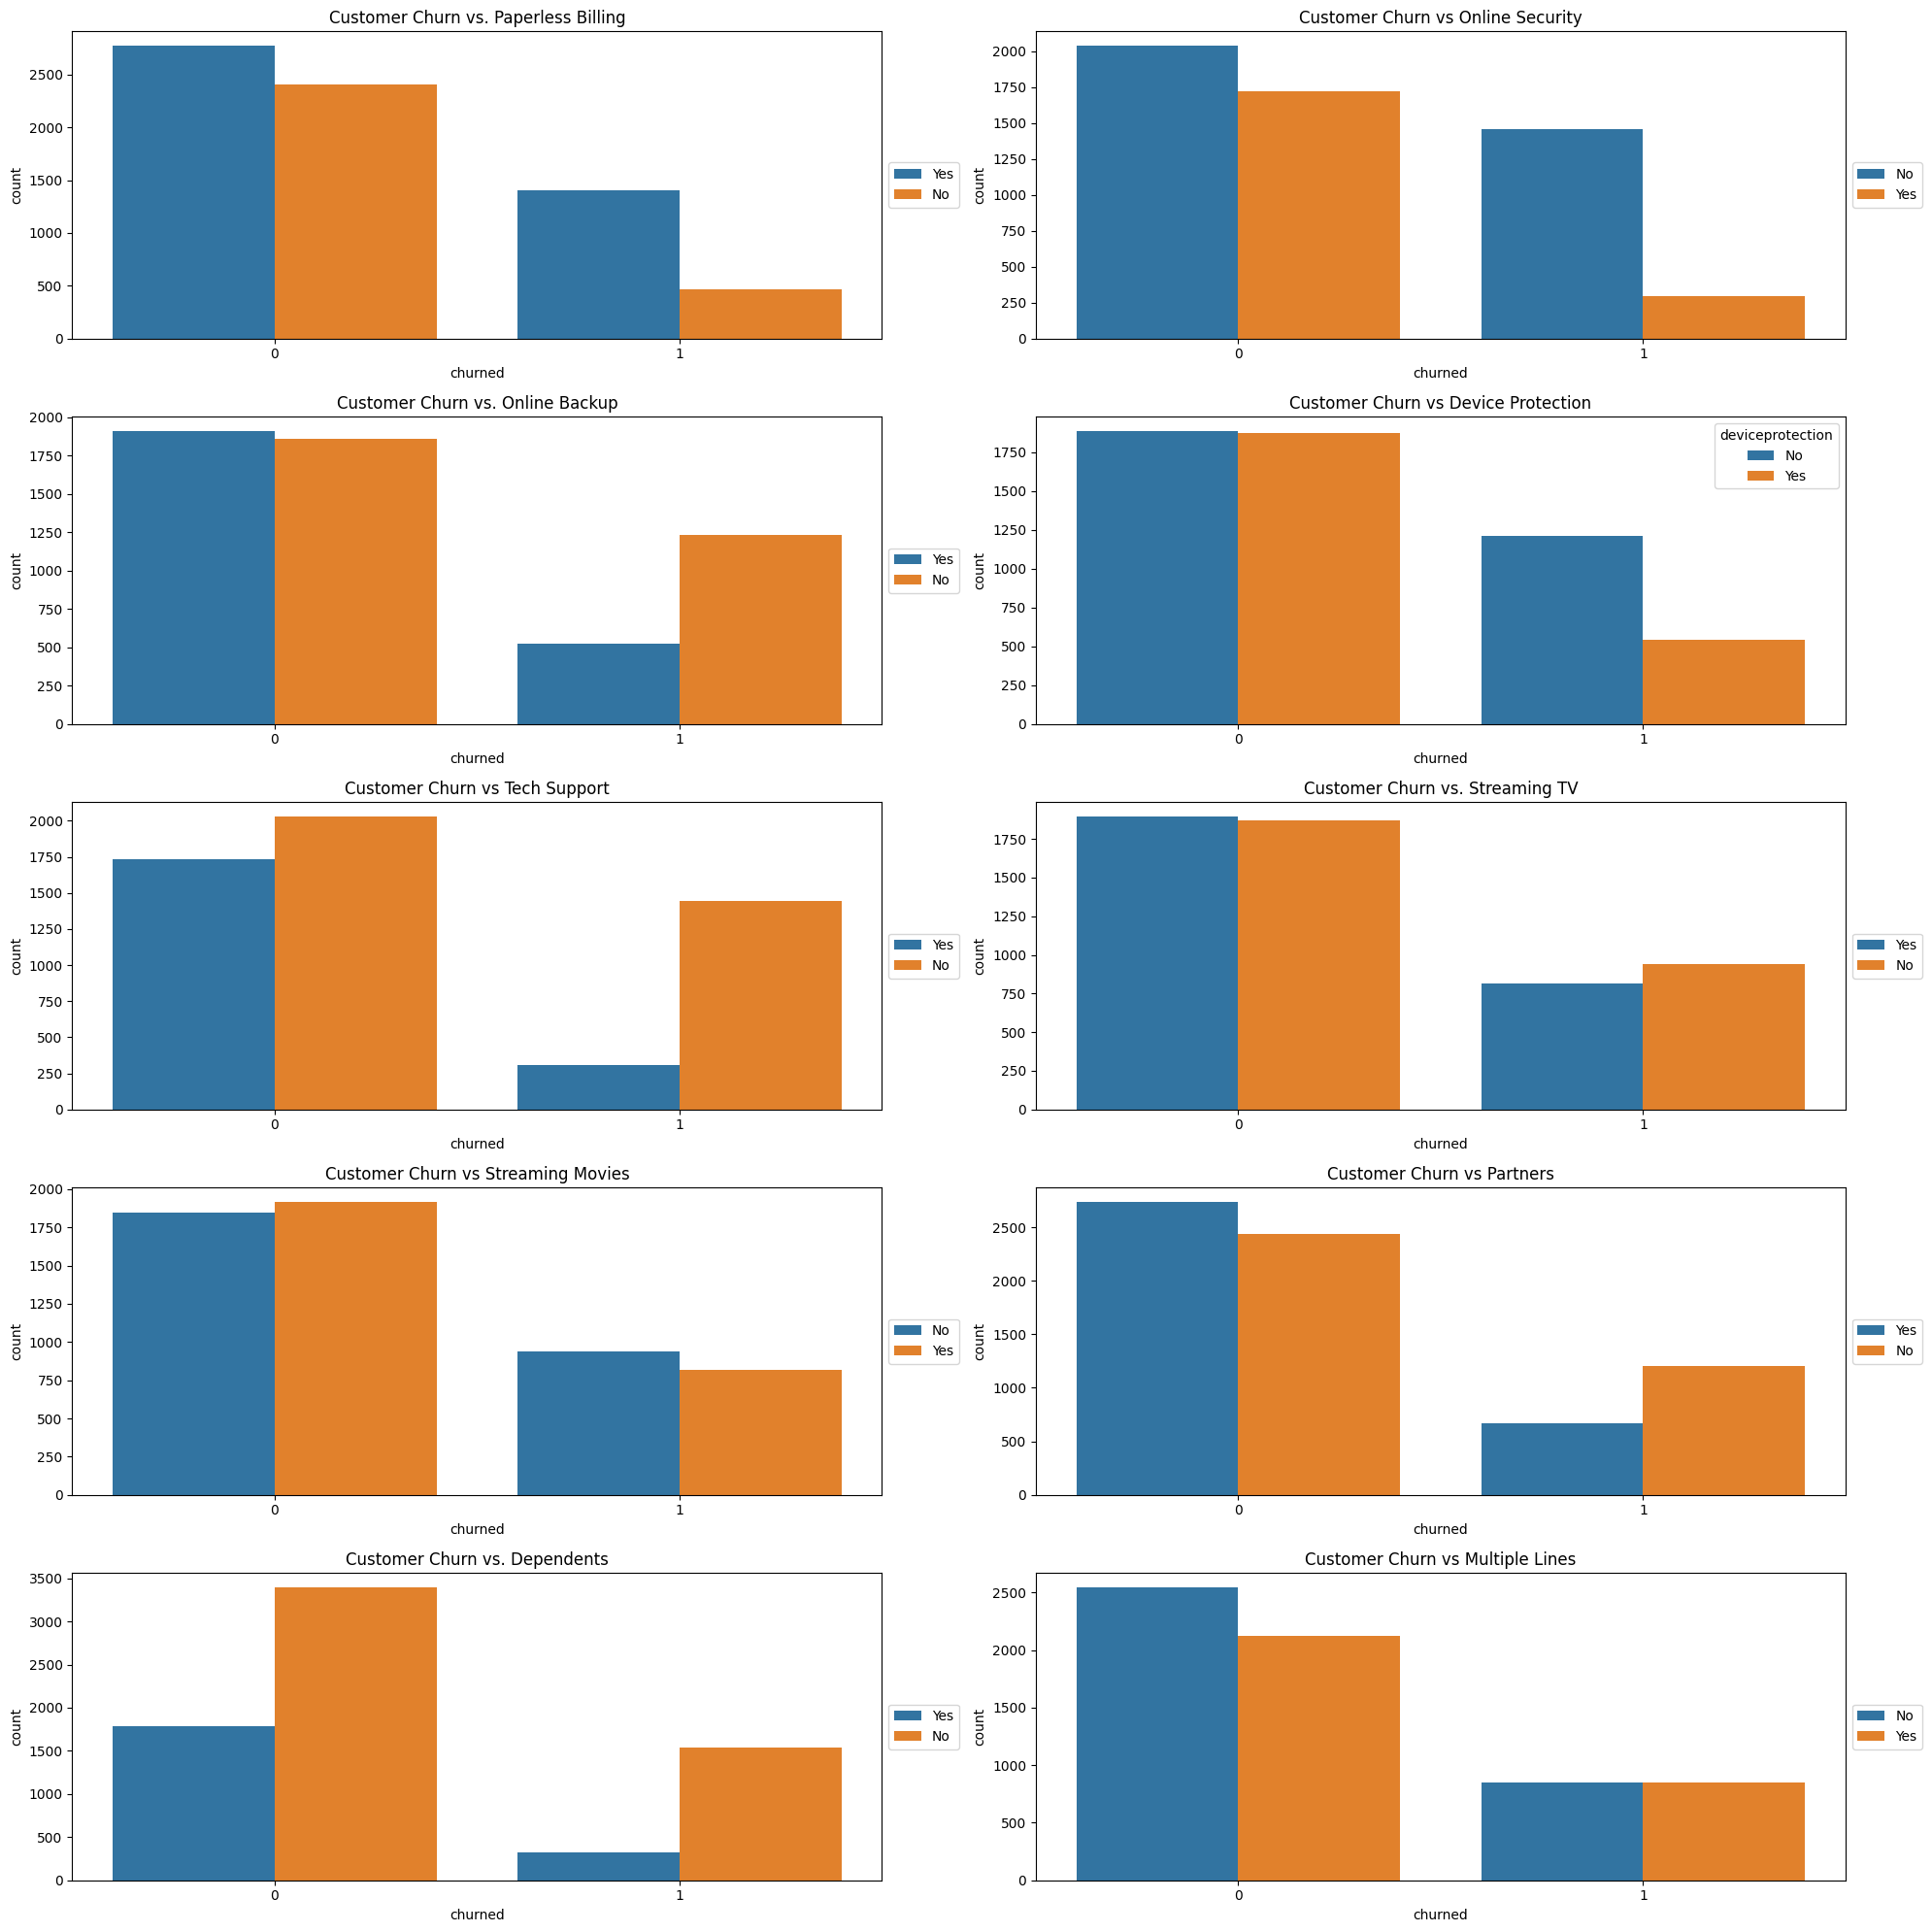

In [43]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

sns.countplot(data=data, x='churned', hue='paperlessbilling', ax=axes[0, 0])
axes[0, 0].set_title('Customer Churn vs. Paperless Billing')
axes[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='onlinesecurity', ax=axes[0, 1])
axes[0, 1].set_title('Customer Churn vs Online Security')
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='onlinebackup', ax=axes[1, 0])
axes[1, 0].set_title('Customer Churn vs. Online Backup')
axes[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='deviceprotection', ax=axes[1, 1])
axes[1, 1].set_title('Customer Churn vs Device Protection')
axes[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='techsupport', ax=axes[2, 0])
axes[2, 0].set_title('Customer Churn vs Tech Support')
axes[2, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='streamingtv', ax=axes[2, 1])
axes[2, 1].set_title('Customer Churn vs. Streaming TV')
axes[2, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='streamingmovies', ax=axes[3, 0])
axes[3, 0].set_title('Customer Churn vs Streaming Movies')
axes[3, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='partner', ax=axes[3, 1])
axes[3, 1].set_title('Customer Churn vs Partners')
axes[3, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='dependents', ax=axes[4, 0])
axes[4, 0].set_title('Customer Churn vs. Dependents')
axes[4, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.countplot(data=data, x='churned', hue='multiplelines', ax=axes[4, 1])
axes[4, 1].set_title('Customer Churn vs Multiple Lines')
axes[4, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()

* One conclusion which can be derived from above is that customers who churned more frequently did either not use or opt into certain services such as online security, online backup, device protection and tech support
    * Its possible that the lack of using these services (or if they were not offered) negatively impacted their experience with Interconnect
* Another conclusion can be that customers no partners or dependents also churned more than those who did

In [44]:
data.describe()

,begindate,enddate,monthlycharges,totalcharges,seniorcitizen,duration
count,7043,7043,7043.000000,7032.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-12-19 18:22:26.358085888,64.761692,2283.300441,0.162147,963.222632
min,2013-10-01 00:00:00,2019-10-01 00:00:00,18.250000,18.800000,0.000000,-31.000000
25%,2015-06-01 00:00:00,2020-01-01 00:00:00,35.500000,401.450000,0.000000,245.000000
50%,2017-09-01 00:00:00,2020-01-01 00:00:00,70.350000,1397.475000,0.000000,852.000000
75%,2019-04-01 00:00:00,2020-01-01 00:00:00,89.850000,3794.737500,0.000000,1675.000000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,8684.800000,1.000000,2191.000000
std,NaN,NaN,30.090047,2266.771362,0.368612,742.870749


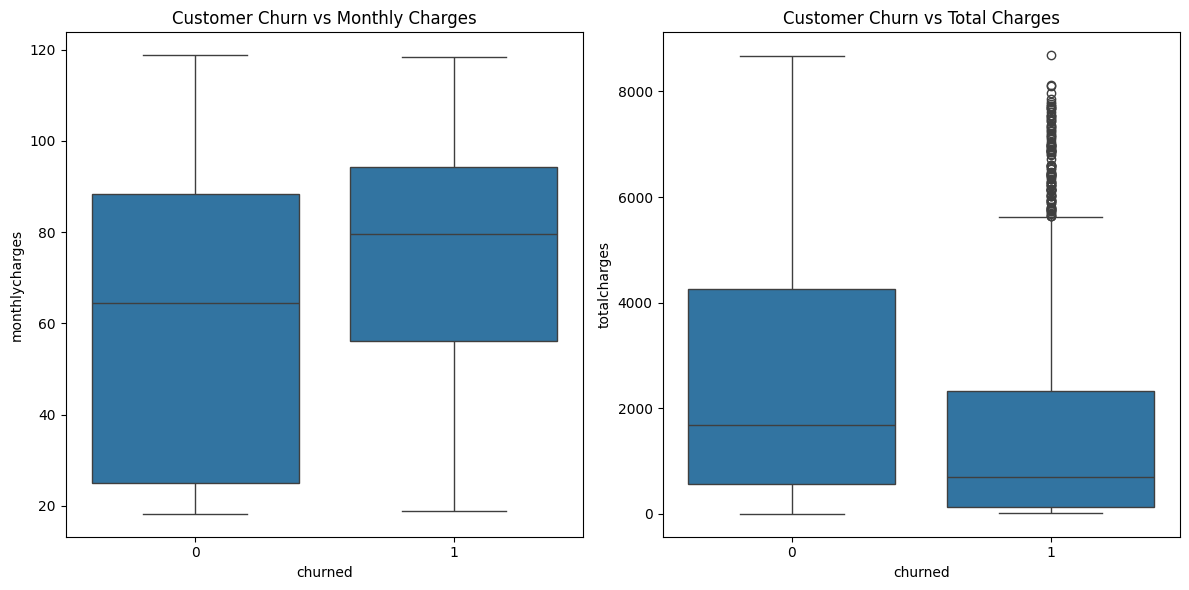

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='churned', y='monthlycharges', data=data, ax=axes[0])
axes[0].set_title('Customer Churn vs Monthly Charges')

sns.boxplot(x='churned', y='totalcharges', data=data, ax=axes[1])
axes[1].set_title('Customer Churn vs Total Charges')

plt.tight_layout()
plt.show()

In [46]:
data[['monthlycharges', 'totalcharges']].describe()

,monthlycharges,totalcharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


* Churned customers have higher monthly charges as indicated by the higher median for churned customers
* For total charges - churned customers had lower charges as shown by the median
    * A contributing factor to this could be because churned customers opt to not stay on a long contract with Interconnect

## Model Preparation

In [47]:
data.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'multiplelines', 'churned', 'duration'],
      dtype='object')

In [48]:
print(data['type'].value_counts())
print(data['paperlessbilling'].value_counts())
print(data['paymentmethod'].value_counts())
print(data['internetservice'].value_counts())
print(data['onlinesecurity'].value_counts())
print(data['onlinebackup'].value_counts())
print(data['deviceprotection'].value_counts())
print(data['techsupport'].value_counts())
print(data['streamingmovies'].value_counts())
print(data['streamingtv'].value_counts())
print(data['gender'].value_counts())
print(data['seniorcitizen'].value_counts())
print(data['partner'].value_counts())
print(data['dependents'].value_counts())
print(data['multiplelines'].value_counts())

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
paperlessbilling
Yes    4171
No     2872
Name: count, dtype: int64
paymentmethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
internetservice
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
onlinesecurity
No     3498
Yes    2019
Name: count, dtype: int64
onlinebackup
No     3088
Yes    2429
Name: count, dtype: int64
deviceprotection
No     3095
Yes    2422
Name: count, dtype: int64
techsupport
No     3473
Yes    2044
Name: count, dtype: int64
streamingmovies
No     2785
Yes    2732
Name: count, dtype: int64
streamingtv
No     2810
Yes    2707
Name: count, dtype: int64
gender
Male      3555
Female    3488
Name: count, dtype: int64
seniorcitizen
0    5901
1    1142
Name: count, dtype: int64
partner
No     3641
Yes    3402
Name: count, dtype: int64
dependent

In [49]:
data['totalcharges'] = data['totalcharges'].fillna(0)

In [50]:
data = data.fillna('unknown')

In [51]:
print(data['type'].value_counts())
print(data['monthlycharges'].value_counts())
print(data['totalcharges'].value_counts())
print(data['duration'].value_counts())
print(data['paperlessbilling'].value_counts())
print(data['paymentmethod'].value_counts())
print(data['internetservice'].value_counts())
print(data['onlinesecurity'].value_counts())
print(data['onlinebackup'].value_counts())
print(data['deviceprotection'].value_counts())
print(data['techsupport'].value_counts())
print(data['streamingmovies'].value_counts())
print(data['streamingtv'].value_counts())
print(data['gender'].value_counts())
print(data['seniorcitizen'].value_counts())
print(data['partner'].value_counts())
print(data['dependents'].value_counts())
print(data['multiplelines'].value_counts())

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
monthlycharges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
116.55     1
106.85     1
68.55      1
108.80     1
67.85      1
Name: count, Length: 1585, dtype: int64
totalcharges
0.00       11
20.20      11
19.75       9
19.90       8
20.05       8
           ..
2387.75     1
6302.80     1
2058.50     1
829.55      1
3707.60     1
Name: count, Length: 6531, dtype: int64
duration
2160    361
31      313
0       233
61      229
30      182
       ... 
1369      2
1552      2
2161      1
1917      1
1218      1
Name: count, Length: 133, dtype: int64
paperlessbilling
Yes    4171
No     2872
Name: count, dtype: int64
paymentmethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
internetservice
Fiber optic    3096
DSL            2421
unknown        1

In [52]:
data.drop(['customerid', 'begindate', 'enddate'], axis=1, inplace=True)
data

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,churned,duration
0,One year,Yes,Mailed check,65.60,593.30,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No,0,245
1,Month-to-month,No,Mailed check,59.90,542.40,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes,0,245
2,Month-to-month,Yes,Electronic check,73.90,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No,1,122
3,Month-to-month,Yes,Electronic check,98.00,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No,1,396
4,Month-to-month,Yes,Mailed check,83.90,267.40,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No,1,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,No,Mailed check,55.15,742.90,DSL,Yes,No,No,Yes,No,No,Female,0,No,No,No,0,365
7039,Month-to-month,Yes,Electronic check,85.10,1873.70,Fiber optic,No,No,No,No,No,Yes,Male,0,Yes,No,Yes,1,668
7040,Month-to-month,Yes,Mailed check,50.30,92.75,DSL,No,Yes,No,No,No,No,Male,0,No,No,No,0,31
7041,Two year,No,Mailed check,67.85,4627.65,DSL,Yes,No,Yes,Yes,No,Yes,Male,0,Yes,Yes,No,0,2010


<div class="alert alert-block alert-info">
<b>Student Comment</b> <a class="tocSkip"></a>

OneHotEncoder + StandardScaler used to transform data prior to splitting

</div>


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

That's nice idea to use a pipeline. But you need to fit the pipeline only on train data. Previously I told you "Scaler should be trained on train data only. After you fit it on train data, you can apply it to all the data parts one by one.". This is why your pipline should be traind on train data only.

</div>

<div class="alert alert-block alert-info">
<b>Student Comment v2</b> <a class="tocSkip"></a>

OK, only using OneHotEncoder before splitting

</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Okay, this is better

</div>

In [53]:
# convert_cols = ['type', 'gender', 'paperlessbilling', 'paymentmethod', 
#                 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
#                 'techsupport', 'streamingmovies', 'streamingtv', 'multiplelines',
#                'partner', 'dependents']

# num_cols = ['monthlycharges', 'totalcharges', 'duration']

# col_transformer = ColumnTransformer([
#     ('onehot', OneHotEncoder(handle_unknown='ignore'), convert_cols),
#     ('scaler', StandardScaler(), num_cols)
# ], remainder='passthrough')

# transform = col_transformer.fit_transform(data)
# transform_features = col_transformer.get_feature_names_out()
# transformed_data = pd.DataFrame(transform, columns=transform_features)

# transformed_data


convert_cols = ['type', 'gender', 'paperlessbilling', 'paymentmethod', 
                'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
                'techsupport', 'streamingmovies', 'streamingtv', 'multiplelines',
               'partner', 'dependents']

# num_cols = ['monthlycharges', 'totalcharges', 'duration']

col_transformer = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), convert_cols)], 
                                    remainder='passthrough')

transform = col_transformer.fit_transform(data)
transform_features = col_transformer.get_feature_names_out()
transformed_data = pd.DataFrame(transform, columns=transform_features)

transformed_data

,onehot__type_Month-to-month,onehot__type_One year,onehot__type_Two year,onehot__gender_Female,onehot__gender_Male,onehot__paperlessbilling_No,onehot__paperlessbilling_Yes,onehot__paymentmethod_Bank transfer (automatic),onehot__paymentmethod_Credit card (automatic),onehot__paymentmethod_Electronic check,...,onehot__multiplelines_unknown,onehot__partner_No,onehot__partner_Yes,onehot__dependents_No,onehot__dependents_Yes,remainder__monthlycharges,remainder__totalcharges,remainder__seniorcitizen,remainder__churned,remainder__duration
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,65.6,593.3,0,0,245
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,59.9,542.4,0,0,245
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,73.9,280.85,0,1,122
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,98.0,1237.85,1,1,396
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,83.9,267.4,1,1,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,55.15,742.9,0,0,365
7039,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,85.1,1873.7,0,1,668
7040,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,50.3,92.75,0,0,31
7041,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,67.85,4627.65,0,0,2010


In [54]:
train, validate_test = train_test_split(transformed_data, test_size=0.3, random_state=12345)

In [55]:
train

,onehot__type_Month-to-month,onehot__type_One year,onehot__type_Two year,onehot__gender_Female,onehot__gender_Male,onehot__paperlessbilling_No,onehot__paperlessbilling_Yes,onehot__paymentmethod_Bank transfer (automatic),onehot__paymentmethod_Credit card (automatic),onehot__paymentmethod_Electronic check,...,onehot__multiplelines_unknown,onehot__partner_No,onehot__partner_Yes,onehot__dependents_No,onehot__dependents_Yes,remainder__monthlycharges,remainder__totalcharges,remainder__seniorcitizen,remainder__churned,remainder__duration
99,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,109.9,3694.7,1,0,975
5684,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,19.65,708.8,0,0,1036
4627,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,93.3,93.3,0,1,31
629,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,75.25,242.0,0,1,91
4084,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,19.4,19.4,0,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,85.95,381.3,0,1,123
3492,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,97.7,3410.0,0,0,1005
2177,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,81.25,4639.45,0,0,1767
3557,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,75.55,75.55,0,0,0


In [56]:
validate_test

,onehot__type_Month-to-month,onehot__type_One year,onehot__type_Two year,onehot__gender_Female,onehot__gender_Male,onehot__paperlessbilling_No,onehot__paperlessbilling_Yes,onehot__paymentmethod_Bank transfer (automatic),onehot__paymentmethod_Credit card (automatic),onehot__paymentmethod_Electronic check,...,onehot__multiplelines_unknown,onehot__partner_No,onehot__partner_Yes,onehot__dependents_No,onehot__dependents_Yes,remainder__monthlycharges,remainder__totalcharges,remainder__seniorcitizen,remainder__churned,remainder__duration
1128,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,19.9,1110.05,0,0,1583
2875,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,103.8,3470.8,0,0,1005
1783,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,30.5,208.7,0,1,184
3804,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,94.95,178.1,0,1,61
6087,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,60.05,4176.7,0,0,2071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,91.3,4126.35,1,0,1370
174,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,103.7,5036.3,0,1,1491
857,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,19.65,1025.05,0,0,1553
6406,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,59.95,1406.0,0,0,671


In [57]:
validate, test = train_test_split(validate_test, test_size=0.5, random_state=12345)

In [58]:
features_train = train.drop('remainder__churned', axis=1)
target_train = train['remainder__churned']

features_validate = validate.drop('remainder__churned', axis=1)
target_validate = validate['remainder__churned']

features_test = test.drop('remainder__churned', axis=1)
target_test = test['remainder__churned']

In [59]:
features_train.columns

Index(['onehot__type_Month-to-month', 'onehot__type_One year',
       'onehot__type_Two year', 'onehot__gender_Female', 'onehot__gender_Male',
       'onehot__paperlessbilling_No', 'onehot__paperlessbilling_Yes',
       'onehot__paymentmethod_Bank transfer (automatic)',
       'onehot__paymentmethod_Credit card (automatic)',
       'onehot__paymentmethod_Electronic check',
       'onehot__paymentmethod_Mailed check', 'onehot__internetservice_DSL',
       'onehot__internetservice_Fiber optic',
       'onehot__internetservice_unknown', 'onehot__onlinesecurity_No',
       'onehot__onlinesecurity_Yes', 'onehot__onlinesecurity_unknown',
       'onehot__onlinebackup_No', 'onehot__onlinebackup_Yes',
       'onehot__onlinebackup_unknown', 'onehot__deviceprotection_No',
       'onehot__deviceprotection_Yes', 'onehot__deviceprotection_unknown',
       'onehot__techsupport_No', 'onehot__techsupport_Yes',
       'onehot__techsupport_unknown', 'onehot__streamingmovies_No',
       'onehot__streaming

In [60]:
features_train

,onehot__type_Month-to-month,onehot__type_One year,onehot__type_Two year,onehot__gender_Female,onehot__gender_Male,onehot__paperlessbilling_No,onehot__paperlessbilling_Yes,onehot__paymentmethod_Bank transfer (automatic),onehot__paymentmethod_Credit card (automatic),onehot__paymentmethod_Electronic check,...,onehot__multiplelines_Yes,onehot__multiplelines_unknown,onehot__partner_No,onehot__partner_Yes,onehot__dependents_No,onehot__dependents_Yes,remainder__monthlycharges,remainder__totalcharges,remainder__seniorcitizen,remainder__duration
99,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,109.9,3694.7,1,975
5684,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,19.65,708.8,0,1036
4627,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,93.3,93.3,0,31
629,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,75.25,242.0,0,91
4084,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,19.4,19.4,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,85.95,381.3,0,123
3492,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,97.7,3410.0,0,1005
2177,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,81.25,4639.45,0,1767
3557,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,75.55,75.55,0,0


In [61]:
# features_train[[num_cols]] = scaler.fit_transform(features_train[[num_cols]])
# features_validate_ohe[['monthlycharges', 'totalcharges', 'duration']] = scaler.fit_transform(features_validate_ohe[['monthlycharges', 'totalcharges', 'duration']])
# features_test_ohe[['monthlycharges', 'totalcharges', 'duration']] = scaler.fit_transform(features_test_ohe[['monthlycharges', 'totalcharges', 'duration']])

scaler = StandardScaler()

num_cols = ['remainder__monthlycharges', 'remainder__totalcharges', 'remainder__duration']

scaler.fit(features_train[num_cols])

features_train[num_cols] = scaler.transform(features_train[num_cols])
features_validate[num_cols] = scaler.transform(features_validate[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [64]:
print(features_train.shape)
print(features_validate.shape)
print(features_test.shape)
print(target_train.shape)
print(target_validate.shape)
print(target_test.shape)

(4930, 43)
(1056, 43)
(1057, 43)
(4930,)
(1056,)
(1057,)


In [65]:
print(target_train.info())
print(target_validate.info())
print(target_test.info())

<class 'pandas.core.series.Series'>
Index: 4930 entries, 99 to 4578
Series name: remainder__churned
Non-Null Count  Dtype 
--------------  ----- 
4930 non-null   object
dtypes: object(1)
memory usage: 77.0+ KB
None
<class 'pandas.core.series.Series'>
Index: 1056 entries, 2146 to 1945
Series name: remainder__churned
Non-Null Count  Dtype 
--------------  ----- 
1056 non-null   object
dtypes: object(1)
memory usage: 16.5+ KB
None
<class 'pandas.core.series.Series'>
Index: 1057 entries, 196 to 3439
Series name: remainder__churned
Non-Null Count  Dtype 
--------------  ----- 
1057 non-null   object
dtypes: object(1)
memory usage: 16.5+ KB
None


In [66]:
target_train = target_train.astype(int)
target_validate = target_validate.astype(int)
target_test = target_test.astype(int)

In [67]:
print(target_train.info())
print(target_validate.info())
print(target_test.info())

<class 'pandas.core.series.Series'>
Index: 4930 entries, 99 to 4578
Series name: remainder__churned
Non-Null Count  Dtype
--------------  -----
4930 non-null   int64
dtypes: int64(1)
memory usage: 77.0 KB
None
<class 'pandas.core.series.Series'>
Index: 1056 entries, 2146 to 1945
Series name: remainder__churned
Non-Null Count  Dtype
--------------  -----
1056 non-null   int64
dtypes: int64(1)
memory usage: 16.5 KB
None
<class 'pandas.core.series.Series'>
Index: 1057 entries, 196 to 3439
Series name: remainder__churned
Non-Null Count  Dtype
--------------  -----
1057 non-null   int64
dtypes: int64(1)
memory usage: 16.5 KB
None


In [68]:
features_train = features_train.astype(int)
features_validate = features_validate.astype(int)
features_test = features_test.astype(int)

## Model Processing

### Logistic Regression

In [69]:
log = LogisticRegression(solver='liblinear', random_state=12345)
log.fit(features_train, target_train)
prediction_valid = log.predict(features_validate)

valid_prob = log.predict_proba(features_validate)
valid_prob2 = valid_prob[:, 1]
auc_roc = roc_auc_score(target_validate, valid_prob2)

print('ROC-AUC Score:', auc_roc)

ROC-AUC Score: 0.8663647067846235


### Decision Tree

In [70]:
d_tree_results = []

for depth in range(1, 25):
    d_tree = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    d_tree.fit(features_train, target_train)
    # predicted_d_tree = d_tree.predict(features_validate_ohe)
    dt_valid_prob = d_tree.predict_proba(features_validate)
    dt_valid_prob2 = dt_valid_prob[:,1]
    d_tree_rocauc = roc_auc_score(target_validate, dt_valid_prob2)
    d_tree_results.append({
        'Depth':depth,
        'ROC-AUC': d_tree_rocauc,
    })

In [71]:
dt_results = pd.DataFrame(d_tree_results).sort_values(by='ROC-AUC', ascending=False)
dt_results

,Depth,ROC-AUC
5,6,0.847370
4,5,0.846014
3,4,0.845418
6,7,0.832415
2,3,0.831697
7,8,0.818750
1,2,0.809192
8,9,0.778127
9,10,0.747718
0,1,0.737311


### Random Forest

In [72]:
rf_results = []

for depth in range(1, 25):
    random_forest = RandomForestClassifier(random_state = 12345, max_depth=depth)
    random_forest.fit(features_train, target_train)
    # predicted_rf = random_forest.predict(features_validate_ohe)
    rf_valid_prob = random_forest.predict_proba(features_validate)
    rf_valid_prob2 = rf_valid_prob[:,1]
    rf_rocauc = roc_auc_score(target_validate, rf_valid_prob2)
    rf_results.append({
        'Depth':depth,
        'ROC-AUC': rf_rocauc,
    })

In [73]:
rf_results = pd.DataFrame(rf_results).sort_values(by='ROC-AUC', ascending=False)
rf_results

,Depth,ROC-AUC
6,7,0.857468
5,6,0.857184
7,8,0.856435
4,5,0.854818
8,9,0.853638
3,4,0.851295
2,3,0.849176
1,2,0.848010
9,10,0.846140
10,11,0.843817


### CatBoost Classifier

In [74]:
cb_model = CatBoostClassifier(loss_function="Logloss", iterations=150, random_seed=12345)

cb_model.fit(features_train, target_train, verbose=10)

cb_prob_valid = cb_model.predict_proba(features_validate)
cb_prob_valid2 = cb_prob_valid[:, 1]
print('ROC-AUC Score: ', roc_auc_score(target_validate, cb_prob_valid2))

Learning rate set to 0.115959
0:	learn: 0.6203962	total: 62.2ms	remaining: 9.27s
10:	learn: 0.4385702	total: 85.4ms	remaining: 1.08s
20:	learn: 0.4136280	total: 104ms	remaining: 640ms
30:	learn: 0.4003121	total: 123ms	remaining: 472ms
40:	learn: 0.3904668	total: 142ms	remaining: 377ms
50:	learn: 0.3832906	total: 160ms	remaining: 311ms
60:	learn: 0.3759106	total: 178ms	remaining: 260ms
70:	learn: 0.3694507	total: 204ms	remaining: 227ms
80:	learn: 0.3617191	total: 223ms	remaining: 190ms
90:	learn: 0.3533097	total: 241ms	remaining: 156ms
100:	learn: 0.3448707	total: 260ms	remaining: 126ms
110:	learn: 0.3383334	total: 279ms	remaining: 98.1ms
120:	learn: 0.3318871	total: 296ms	remaining: 71ms
130:	learn: 0.3259946	total: 314ms	remaining: 45.6ms
140:	learn: 0.3199939	total: 332ms	remaining: 21.2ms
149:	learn: 0.3151676	total: 349ms	remaining: 0us
ROC-AUC Score:  0.8431673305874232


### Light GBM

In [75]:
lgbm_results = []

for depth in range(1, 25):
    lgbm_model = LGBMClassifier(max_depth=depth, random_seed=12345)
    lgbm_model.fit(features_train, target_train)
    lgbm_model_prob = lgbm_model.predict_proba(features_validate)
    lgbm_model_prob2 = lgbm_model_prob[:,1]
    lgbm_rocauc = roc_auc_score(target_validate, lgbm_model_prob2)
    lgbm_results.append({
        'Depth':depth,
        'ROC-AUC': lgbm_rocauc,
    })

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1302, number of negative: 3628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264097 -> initscore=-1.024780
[LightGBM] [Info] Start training from score -1.024780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [76]:
lgbm_results_df = pd.DataFrame(lgbm_results)
lgbm_results_df.sort_values(by='ROC-AUC', ascending=False)

,Depth,ROC-AUC
1,2,0.865097
0,1,0.863511
2,3,0.862625
3,4,0.852813
14,15,0.848788
22,23,0.848788
21,22,0.848788
20,21,0.848788
19,20,0.848788
18,19,0.848788


### XGBoost

In [77]:
target_train

99      0
5684    0
4627    1
629     1
4084    1
       ..
3497    1
3492    0
2177    0
3557    0
4578    0
Name: remainder__churned, Length: 4930, dtype: int64

In [78]:
xg_results = []

for depth in range(1, 25):
    xg_model = XGBClassifier(max_depth=depth, random_state=12345)
    xg_model.fit(features_train, target_train)
    xg_prob = xg_model.predict_proba(features_validate)
    xg_prob2 = xg_prob[:,1]
    xg_rocauc = roc_auc_score(target_validate, xg_prob2)
    xg_results.append({
        'Depth':depth,
        'ROC-AUC': xg_rocauc,
    })

In [79]:
xg_results_df = pd.DataFrame(xg_results)
xg_results_df.sort_values(by='ROC-AUC', ascending=False)

,Depth,ROC-AUC
0,1,0.868453
1,2,0.863198
2,3,0.851256
3,4,0.836865
4,5,0.818653
5,6,0.815436
6,7,0.811128
7,8,0.803485
8,9,0.796547
9,10,0.795040


### Testing Best Model - XGBoost

In [80]:
xg_model2 = XGBClassifier(max_depth=1, n_estimators=50, random_state=12345)
xg_model2.fit(features_train, target_train)
xg_prob3 = xg_model2.predict_proba(features_test)
xg_prob4 = xg_prob3[:,1]
xg_rocauc2 = roc_auc_score(target_test, xg_prob4)
print('ROC-AUC Score: ', xg_rocauc2)

ROC-AUC Score:  0.8503638680839667


# Conclusion
* The model built using XGBClassifer ended up having the best ROC-AUC score of 0.8684 when using training data at a depth of 1
    * We validated the model using test data and ended up with a ROC-AUC Score of 0.8503, which aligns with our findings that XGBClassifier was the best model
* Interconnect could use XGBClassifier to predict customer churn
* It's important to also note customers who had a fiber optic connection and were on the month-to-month plan were more likely to churn
    * It's possible by not offering a month-to-month contract maybe customers would stay longer

# Solution Report
1. **What steps of the plan were performed and what steps were skipped (explain why)?**
    * Steps performed were as follows:
        * Data Loading & Preprocessing
        * EDA
        * Model Preparation
        * Model Processing
        * Hyper Parameter Tuning
        * Conclusion
    * There were not any steps which were necissarily skipped from the work plan, but some steps deviated from the original work plan:  
        * Datasets were merged prior to data conversion
        * There was a small amount of feature engineering to add data to the merged dataset such as including contract duration in days and also adding in a "churned" column which was not dependent on dates
        * The dataset was also one-hot encoded for YES/NO columns before splitting into training/validation/testing datasets. After splitting the numerical columns were scaled to the training dataset and then the validation/testing datasets were also scaled to the training dataset
2. **What difficulties did you encounter and how did you manage to solve them?**
    * Difficulties with this project included preprocessing the data and encoding/scaling
    * Preprocessing solutions
        * There were four CSV files which were all needed to be utilized to arrive at a conclusion - these four datasets were merged
        * It was clear that some columns had incorrect datatypes, so these were corrected (total charges, begin date, and end date)
        * Feature Engineering
            * Two features were added to provide more insight into the data and also provide a designated target column in the correct format:
                * 'Churned' - to show the target as 1s and 0s versus a datetime column
                * Duration - the amount of time in days the customer spent with the company
        * Filling in the blanks
            * Although data was not necissarily missing from the four provided CSV files, all four datasets did not have the same size
            * Because of this difference in size, some information from each customer was missing
            * A value of 'unknown' was added in the missing information of these columns
    * Encoding/scaling solution 
        * Many columns contained the values of "YES/NO"
        * Since our target was a numerical value, these columns needed to be encoded into 1s and 0s
        * There were three primary numerical columns which reflected different values (total charges, monthly charges, and duration)
            * These three columns were scaled to the training subset of data, and then the scaler was applied to the validation and testing datasets  
3. **What were some of the key steps to solving the task?**
    * Key steps to solving this task included:
        1. Preprocessing the data to merge all dataframes
        2. Adjusting the dataframe (adding in columns, encoding, scaling) for usage with machine learning models
        3. Testing out various different models and hyperparameters
        4. Selecting the best model and using the model with the testing data subset
4. **What is your final model and what quality score does it have?**
    * The final model used was an XGBClassifer with a ROC-AUC score of 0.8684 when using training data at a depth of 1

